In [1]:
%load_ext autoreload
%autoreload 2
%cd '~/carl/research/diff_reset'
%pwd
%matplotlib inline
import matplotlib.pyplot as plt
import taichi as ti
import numpy as np
import cv2
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "2"
from plb.utils.visualization_utils import save_rgb
target_path = './datasets/0513_Roll/init'
if not os.path.exists(target_path):
    os.makedirs(target_path, exist_ok=True)

/home/jianrenw/carl/research/dev/PlasticineLab
[Taichi] mode=release
[Taichi] preparing sandbox at /tmp/taichi-r93qnmtw
[Taichi] version 0.7.26, llvm 10.0.0, commit e37bdb5e, linux, python 3.8.11
[I 05/14/22 17:16:03.840 2993484] [shell.py:_shell_pop_print@35] Graphical python shell detected, using wrapped sys.stdout


pimirives: num primitive: 2
Building primitive
action:
  dim: 6
  scale: (0.7, 0.05, 0.005, 0.005, 0.0, 0.0)
collision_group: [0.0, 0.0, 0.0]
color: (1.0, 0.0, 0.0)
friction: 0.9
h: 0.23
init_pos: (0.5, 0.25, 0.45)
init_rot: (0.707, 0.707, 0.0, 0.0)
lower_bound: (0.0, 0.04, 0.0)
r: 0.04
shape: RollingPinExt
upper_bound: (1.0, 1.0, 1.0)
variations: None
Building primitive
action:
  dim: 0
  scale: ()
collision_group: [0.0, 0.0, 0.0]
color: (0.5, 0.5, 0.5)
friction: 5.0
init_pos: (0.5, 0.02, 0.45)
init_rot: (1.0, 0.0, 0.0, 0.0)
lower_bound: (0.0, 0.0, 0.0)
shape: Box
size: (0.5, 0.02, 0.45)
upper_bound: (1.0, 1.0, 1.0)
variations: None
Initialize Tina Renderer
bake_size: 6  
cam_center: (0.5, 0.2, 0.45)  
cam_phi: -0.8  
cam_radius: 0.8  
cam_theta: 0.0  
camera_pos: (0.5, 1.2, 4.0)  
camera_rot: (0.2, 0)  
dx: 0.006666666666666667  
image_res: (128, 128)  
light_direction: (0.0, 1.0, 1.0)  
max_num_particles: 1000000  
max_ray_depth: 2  
mesh: False  
name: tina  
sdf_threshold: 0.20720

 n


Env reset: No initial state during cache generation
Generating target, skipping setting emd
emd after reset: 0.0
======================WARNING: contact loss mask not set================
case1 new pos: (0.521518936637242, 0.15646440511781975, 0.5102763376071644) radius: 0.11646440511781975
tool pos: (0.5177016766041873, 0.3401729693854843, 0.4572947056533328)
(0.5177016766041873, 0.3401729693854843, 0.4572947056533328)
Env reset: No initial state during cache generation
Generating target, skipping setting emd
emd after reset: 0.0
======================WARNING: contact loss mask not set================
case1 new pos: (0.5391773000782081, 0.15312761633788077, 0.546366276050103) radius: 0.11312761633788078
tool pos: (0.5537635519823413, 0.32542730861705044, 0.4514447459876452)
(0.5537635519823413, 0.32542730861705044, 0.4514447459876452)
Env reset: No initial state during cache generation
Generating target, skipping setting emd
emd after reset: 0.0
======================WARNING: contact lo

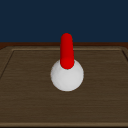

In [4]:
import lzma
import pickle
import numpy as np
import os
from plb.utils.visualization_utils import save_numpy_as_gif
from imitation.env_spec import set_render_mode
np.random.seed(0)
from plb.envs.multitask_env import MultitaskPlasticineEnv
env = MultitaskPlasticineEnv(cfg_path=f'roll_dev.yml', generating_cached_state=True)
set_render_mode(env, 'Roll-v1', 'mesh')
taichi_env = env.taichi_env
np.random.seed(0)
def rand(a, b):
    return np.random.random() * (b - a) + a

N1, N2 = 1, 100
xs = np.linspace(0.45, 0.55, N1)
zs = np.linspace(0.45, 0.55, N1)

def randomize_tool_state(cfg, box_min_x, pin_min_y, x, z):
    # No change on the init position of the box
#         pos = eval(cfg.PRIMITIVES[1]['init_pos'])
#         box_dist = np.random.rand() * 0.1 + 0.05
#         cfg.PRIMITIVES[1]['init_pos'] = (float(box_min_x + box_dist), pos[1], pos[2])

    pos = eval(cfg.PRIMITIVES[0]['init_pos'])
    height = np.random.rand() * 0.05
    # height = 0.01
    x_shift = np.random.rand() * 0.05 - 0.025
    z_shift = np.random.rand() * 0.05 - 0.025
    new_pos = (float(x + x_shift), float(pin_min_y+height), float(zs + z_shift))
    # new_pos = (0.273, 0.2588, 0.5)
    print("tool pos:", new_pos)

    cfg.PRIMITIVES[0]['init_pos'] = new_pos
    print(new_pos)


def case1(cfg): # Sphere
    # rs = np.linspace(0.10, 0.12, N2)
    r = rand(0.10, 0.13)
    # print('setting x pos {}, radius {}'.format(xs[i], fs[k]))
    pos = eval(cfg.SHAPES[0]['init_pos'])
    cfg.SHAPES[0]['radius'] = r
    
    x = rand(0.45, 0.55)
    z = rand(0.45, 0.55)
    new_pos = (x, r + 0.04, z)
    print('case1 new pos:', new_pos, 'radius:', r) 
    cfg.SHAPES[0]['init_pos'] = new_pos
    randomize_tool_state(cfg, 0, r*2+0.04+0.04, x, z)


target_id =0 
target_imgs = []
gifpath = os.path.join(target_path, 'vis_all.gif')
# for case_id, case in enumerate([case1, case11]):
for case_id, case in enumerate([case1]):
    for i in range(N1):
        for j in range(N1):
            for k in range(N2):
                env.reset(target_cfg_modifier=case)
                img = taichi_env.render(mode='rgb', img_size=128)
                state = taichi_env.get_state()
                state_name = os.path.join(target_path, f'state_{target_id}.xz')
                with lzma.open(state_name, 'wb') as f:
                    pickle.dump(state, f, protocol=4)
                save_rgb(os.path.join(target_path, f'state_{target_id}.png'), np.array(img[:, :, :3]).astype(np.float32))
                target_id += 1
                target_imgs.append(img)
save_numpy_as_gif(np.array(target_imgs)[:, :, :, :3], gifpath)
from IPython.display import Image
Image(gifpath)

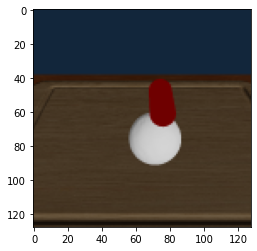

In [7]:
import matplotlib.pyplot as plt
from imitation.env_spec import set_render_mode
env.taichi_env.renderer.update_camera((0.5, 0.15, 0.45), 0., -0.8, 0.8)
set_render_mode(env, 'Roll-v1', 'mesh')
# taichi_env.renderer.verbose = True
img = taichi_env.render(mode='rgb', img_size=128)
plt.imshow(img[:, :, :3])
# taichi_env.render(mode='human', img_size=256)

In [8]:
taichi_env.primitives[1].position.to_numpy()

array([[0.28, 0.04, 0.5 ],
       [0.28, 0.04, 0.5 ],
       [0.28, 0.04, 0.5 ],
       ...,
       [0.  , 0.  , 0.  ],
       [0.  , 0.  , 0.  ],
       [0.  , 0.  , 0.  ]], dtype=float32)

Setting pykeops dir to  ~/.cache/pykeops_2080/
[Taichi] Starting on arch=cuda
[Tina] version 0.1.1
[Tina] Taichi properties hacked
pimirives: num primitive: 2
Building primitive
action:
  dim: 6
  scale: (0.05, 0.05, 0.05, 0.0, 0.05, 0.05)
collision_group: [0, 1]
color: (0.7568, 0.6039, 0.4196)
friction: 0.9
h: 0.3
init_pos: (0.32, 0.25, 0.5)
init_rot: (0.707, 0.707, 0.0, 0.0)
lower_bound: (0.0, 0.16, 0.0)
r: 0.03
shape: RollingPinExt
upper_bound: (1.0, 1.0, 1.0)
variations: None
Building primitive
action:
  dim: 0
  scale: ()
collision_group: [0.0, 0.0, 0.0]
color: (0.5, 0.5, 0.5)
friction: 5.0
init_pos: (0.28, 0.04, 0.5)
init_rot: (1.0, 0.0, 0.0, 0.0)
lower_bound: (0.0, 0.0, 0.0)
shape: Box
size: (0.7, 0.02, 0.43)
upper_bound: (1.0, 1.0, 1.0)
variations: None
Initialize Tina Renderer
bake_size: 6  
cam_center: (0.3, 0.2, 0.5)  
cam_phi: -0.6  
cam_radius: 1.5  
cam_theta: 0.0  
camera_pos: (0.5, 1.2, 4.0)  
camera_rot: (0.2, 0)  
dx: 0.006666666666666667  
image_res: (128, 128)  
lig

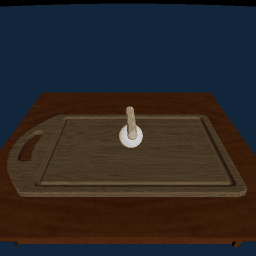

In [2]:
import lzma
import pickle
import numpy as np
import os
from plb.utils.visualization_utils import save_numpy_as_gif
from imitation.env_spec import set_render_mode
from scipy.spatial.transform import Rotation as R

np.random.seed(0)
from plb.envs.multitask_env import MultitaskPlasticineEnv
env = MultitaskPlasticineEnv(cfg_path=f'roll.yml')
set_render_mode(env, 'Roll-v1', 'mesh')
taichi_env = env.taichi_env
gifpath = os.path.join(target_path, 'vis_init.gif')
imgs = []
obs = []
reset_target = env.reset()
for i in range(50):
    ob, _, _, _ = env.step([0,0,0,0,0, 10])
    obs.append(ob)
    img = taichi_env.render(mode='rgb', img_size=256)
    imgs.append(img)
save_numpy_as_gif(np.array(imgs)[:, :, :, :3], gifpath)
from IPython.display import Image
Image(gifpath)

In [9]:
print(reset_target[-13:-9])
print(taichi_env.primitives[0].inv_action(ob[-16:-9], reset_target[-16:-9]))
ob, _, _, _ = env.step(taichi_env.primitives[0].inv_action(obs[-1][-16:-9], reset_target[-16:-9]))
print(obs[-1][-16:-9])

[0.707 0.707 0.    0.   ]
called inverse action !!!!
[  0.       0.       0.       0.      58.8319 -16.3911]
called inverse action !!!!
[ 0.32   0.25   0.5    0.223  0.223  0.671 -0.671]
